---
title: "Exploratory Data Analysis"
format:
    html: 
        code-fold: false
        embed-resources: true
---

## Introduction and Motivation
This is the page for exploratory data analysis. After making our processed data files, we wanted to explore the distributions of various features, the correlation between aspects of songs, and the statistical significance of differences between different categories. This will help us understand the data better, look for any preliminary interesting patterns and insights, and make informed decisions about the models we build as we go forward. Specifically, we looked at the song lyrics and the metadata about the music, their relationships, and their contribution onn song popularity and chart rankings. It will also allow us to look for anomalies to make sure that our data is suitable for ML tasks.

## Overview of Methods
This section uses data visualization, aggregation techniques, and conducts statistical tests to do a preliminary analysis of the data. We used the following methods:
- skew, kurtosis: methods to determine the skewness and deviation from normal distribution of the data
- MinMaxScaler: method to rescale data to be in the same range as other features in dataset
- Ttest_ind: method from scipy.stats to run a t test to check for independence between two groups
- f_oneway: method from scipy.stats to run a one-way anova test to check for independce between multiple groups

## Code

### Step 1: Import data and clean data
- Imported the data using pandas
- Isolated the rows that I thought might be helpful to analyze for this section of the analysis
- Replaced the null values in genre with "None listed" so I can still use the rest of the data (4 rows)
- Change VADER results into indvidual columns
- Displayed the results

In [32]:
import pandas as pd
import ast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

In [33]:
df = pd.read_csv('../../data/processed-data/artist_song_masterlist.csv')
df.head()

,Track ID,Track Name,Song Popularity,Album,Song Release Date,Duration (ms),Artists,Explicit,Song Rank,Artist ID,...,Genre_trap latino,Genre_trap queen,Genre_twee pop,Genre_uk alternative pop,Genre_uk contemporary r&b,Genre_uk pop,Genre_urbano latino,Genre_viral rap,Genre_west coast rap,Genre_wonky
0,0WbMK4wrZ1wFSty9F7FCgu,"Good Luck, Babe!",93.0,"Good Luck, Babe!",2024-04-05,218423.0,Chappell Roan,False,1,7GlBOeep6PqTfFi59PTUUN,...,0,0,0,0,0,0,0,0,0,0
1,6AI3ezQ4o3HUoP6Dhudph3,Not Like Us,88.0,Not Like Us,2024-05-04,274192.0,Kendrick Lamar,True,2,2YZyLoL8N0Wb9xBt1NhZWg,...,0,0,0,0,0,0,0,0,1,0
2,2FQrifJ1N335Ljm3TjTVVf,A Bar Song (Tipsy),86.0,A Bar Song (Tipsy),2024-04-12,171291.0,Shaboozey,True,3,3y2cIKLjiOlp1Np37WiUdH,...,0,0,0,0,0,0,0,0,0,0
3,2HRqTpkrJO5ggZyyK6NPWz,Espresso,88.0,Short n' Sweet,2024-08-23,175459.0,Sabrina Carpenter,True,4,74KM79TiuVKeVCqs8QtB0B,...,0,0,0,0,0,0,0,0,0,0
4,6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,96.0,HIT ME HARD AND SOFT,2024-05-17,210373.0,Billie Eilish,False,5,6qqNVTkY8uBg9cP3Jd7DAH,...,0,0,0,0,0,0,0,0,0,0


In [34]:
df_cl = df[['Track Name','Song Popularity','Album','Song Release Date','Duration (ms)','Artists','Explicit','Song Rank','Artist ID','Genres','Followers','Popularity','Lyrics','Total Artists On Song','Lyrics Word Count','Sentiment (VADER)']]
df_cl.loc[df_cl['Genres'].isna(), 'Genres'] = 'None Listed'
df_cl.loc[df_cl['Lyrics'] == "Lyrics not found!", 'Lyrics Word Count'] = 0
df_cl.loc[df_cl['Lyrics'] == "Lyrics not found!", 'Lyrics'] = ' '
df_cl = df_cl.dropna(subset='Lyrics')
df_cl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94 entries, 0 to 97
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Track Name             94 non-null     object 
 1   Song Popularity        94 non-null     float64
 2   Album                  94 non-null     object 
 3   Song Release Date      94 non-null     object 
 4   Duration (ms)          94 non-null     float64
 5   Artists                94 non-null     object 
 6   Explicit               94 non-null     bool   
 7   Song Rank              94 non-null     int64  
 8   Artist ID              94 non-null     object 
 9   Genres                 94 non-null     object 
 10  Followers              94 non-null     int64  
 11  Popularity             94 non-null     int64  
 12  Lyrics                 94 non-null     object 
 13  Total Artists On Song  94 non-null     float64
 14  Lyrics Word Count      94 non-null     int64  
 15  Sentiment (VA

In [35]:
df_cl["Sentiment (VADER)"] = df_cl["Sentiment (VADER)"].apply(ast.literal_eval)

# Expand the dictionary into separate columns
sentiment_df = pd.json_normalize(df_cl["Sentiment (VADER)"])
sentiment_df = sentiment_df.reset_index(drop=True)

# Combine the expanded columns back with the original DataFrame
df_cl = df_cl.reset_index(drop=True)
df_cl = pd.concat([df_cl.drop(columns=["Sentiment (VADER)"]), sentiment_df], axis=1)
df_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Track Name             94 non-null     object 
 1   Song Popularity        94 non-null     float64
 2   Album                  94 non-null     object 
 3   Song Release Date      94 non-null     object 
 4   Duration (ms)          94 non-null     float64
 5   Artists                94 non-null     object 
 6   Explicit               94 non-null     bool   
 7   Song Rank              94 non-null     int64  
 8   Artist ID              94 non-null     object 
 9   Genres                 94 non-null     object 
 10  Followers              94 non-null     int64  
 11  Popularity             94 non-null     int64  
 12  Lyrics                 94 non-null     object 
 13  Total Artists On Song  94 non-null     float64
 14  Lyrics Word Count      94 non-null     int64  
 15  neg     

### Univariate Analysis

#### Summary Statistics
I ran .describe on the dataset to understand the distributiopn of values and decide if it was worth normalizing the data due to the wide range of possibilities for values for several of the columns. Duration, followers, and word count all range from very low to very high values, so it might be worth normalizing these columns before analysis.

In [36]:
df_cl.describe()

,Song Popularity,Duration (ms),Song Rank,Followers,Popularity,Total Artists On Song,Lyrics Word Count,neg,neu,pos,compound
count,94.000000,94.000000,94.000000,9.400000e+01,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.00000
mean,63.510638,212252.319149,49.372340,1.163717e+07,72.627660,1.319149,233.702128,0.092543,0.767011,0.140436,0.29302
std,19.227973,57749.294460,29.438467,2.373635e+07,17.228374,0.882479,179.263177,0.071248,0.107798,0.077664,0.79927
min,17.000000,120792.000000,1.000000,1.273000e+03,29.000000,1.000000,0.000000,0.000000,0.454000,0.000000,-0.99980
25%,48.250000,175601.000000,24.250000,2.208655e+05,60.000000,1.000000,132.500000,0.034250,0.701250,0.093750,-0.68960
50%,66.000000,196731.500000,48.500000,1.710836e+06,77.000000,1.000000,169.000000,0.084000,0.757500,0.131000,0.71875
75%,77.750000,241314.500000,75.500000,8.641217e+06,86.750000,1.000000,258.750000,0.140750,0.851000,0.189750,0.96500
max,98.000000,456933.000000,100.000000,1.280014e+08,100.000000,8.000000,1160.000000,0.373000,1.000000,0.426000,0.99840


#### Histograms

The next step is checking the distributions of all of my numeric variables to see if there's anything interesting. Keeping in mind that these are considered the top 100 songs of the week that we chose, I analyzed the characteristics of the songs and their lyrics.

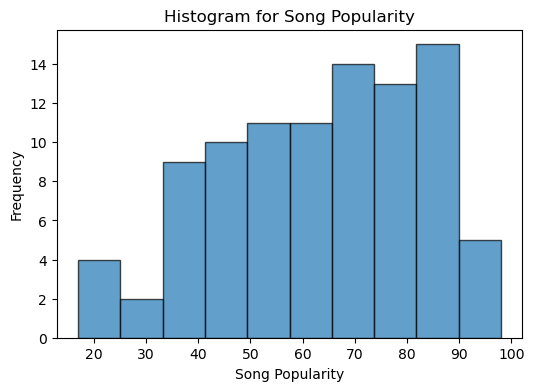

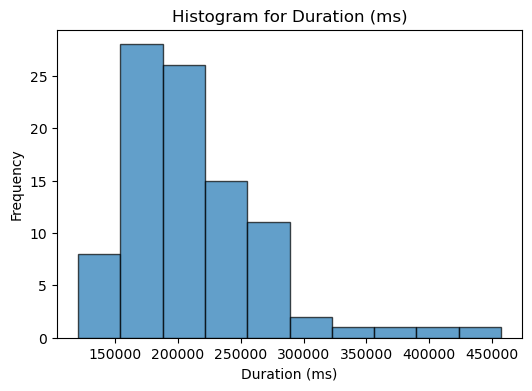

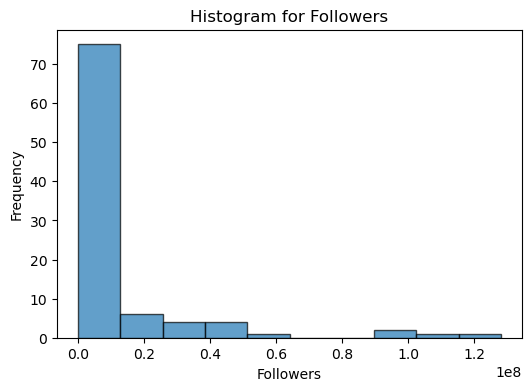

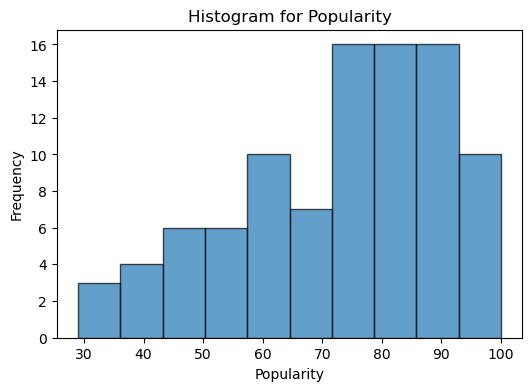

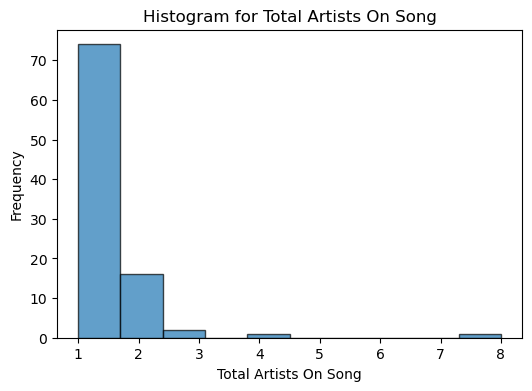

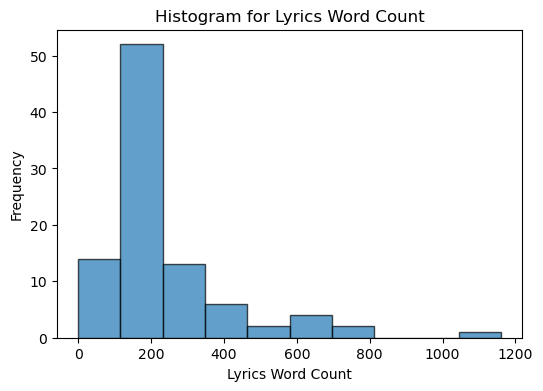

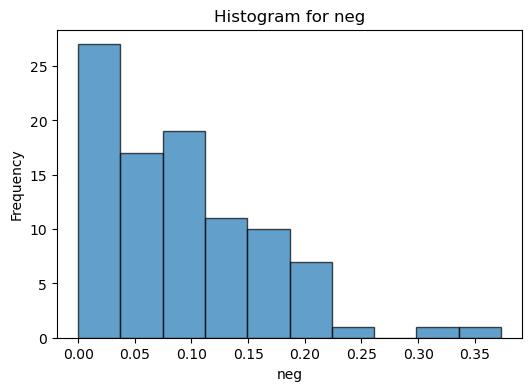

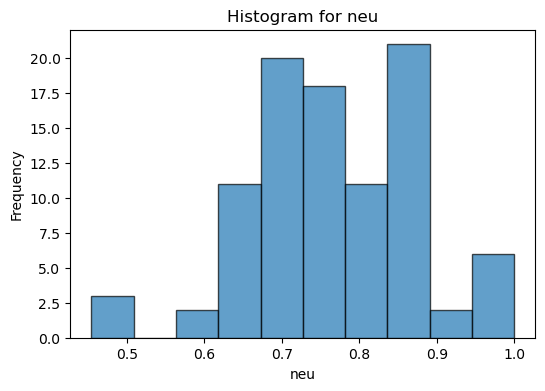

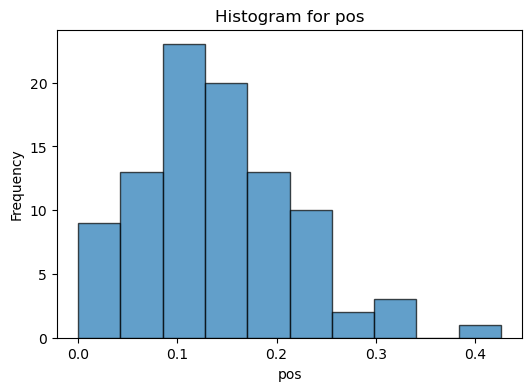

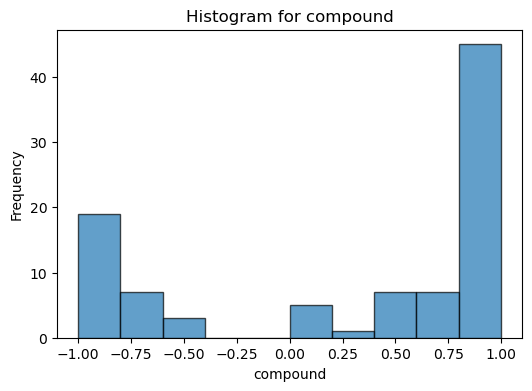

In [37]:
# Create individual histograms for selected columns
columns_to_plot = ['Song Popularity', 'Duration (ms)', 'Followers', 'Popularity', 'Total Artists On Song', 'Lyrics Word Count', 'neg', 'neu', 'pos', 'compound']
for column in columns_to_plot:
    plt.figure(figsize=(6, 4))
    plt.hist(df_cl[column], edgecolor='black', alpha=0.7)
    plt.title(f"Histogram for {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()


From the above graphs, it is interesting to observe that the popularity of the song is not as heavily skewed as I thought. Since these are the top songs, I expected the spotify popularity score to be generally very high, but this was not the case. Additionally, it is interesting to see so many trending songs from artists without very many followers on Spotify. I think this is indicative of the popularity that Tik Tok and other social media platforms can provide for less known artists. Despite this, the popularity of the artists on Spotify seems to be heavily skewed. Moving on to analysis about characteristics about the lyrics, it appears that the songs are largely not negative and tend to be more neutral or positive. This can be seen by the histogram for the compound score as well, with this graph showing a large number of songs with a positive compound score.

#### Genre Analysis
I decided to group the really diverse genres into distinct categories. I used chatgpt to create the categories and asked it to give preference to genres that are not pop if multiple genres are included. Then I mapped the genre column to my new categories and made a histogram.

In [38]:
def map_genres_to_categories(genres):
    # Define the mapping of specific genres to broader categories
    genre_mapping = {
        "Pop": [
            "pop", "social media pop", "dance pop", "modern country pop", "gen z singer-songwriter", "colombian pop", 
            "modern indie pop", "power pop", "la pop", "singer-songwriter pop", "uk pop", "alt z"
        ],
        "Indie/Alternative": [
            "indie pop", "modern alternative pop", "indie rock", "small room", "asheville indie", "sacramento indie", 
            "twee pop", "tape club", "bubblegrunge", "bedroom pop", "slacker rock", "irish indie rock", "irish post-punk"
        ],
        "Rock": [
            "album rock", "blues rock", "classic rock", "electric blues", "hard rock", "jam band", "southern rock", 
            "heartland rock", "garage rock", "modern blues rock", "modern rock", "punk blues", "noise rock", "no wave"
        ],
        "Country": [
            "classic texas country", "contemporary country", "country dawn", "country road", "countrygaze", 
            "deep new americana", "roots americana", "classic oklahoma country", "red dirt"
        ],
        "Hip Hop/Rap": [
            "hip hop", "rap", "west coast rap", "pop rap", "melodic rap", "houston rap", "atl hip hop", "trap", 
            "trap queen", "viral rap", "southern hip hop", "dfw rap", "canadian hip hop", "indian underground rap", 
            "desi hip hop", "malayalam hip hop", "irish hip hop", "conscious hip hop"
        ],
        "R&B": [
            "r&b", "alternative r&b", "uk contemporary r&b", "afro r&b"
        ],
        "Latin": [
            "reggaeton", "urbano latino", "trap latino", "reggaeton chileno", "reggaeton colombiano", "latin pop"
        ],
        "Afrobeat/African": [
            "afrobeats", "afropop", "azonto", "nigerian pop", "alte", "nigerian hip hop"
        ],
        "Electronic/Experimental": [
            "art pop", "metropopolis", "ambient folk", "freak folk", "hyperpop", "proto-hyperpop", "bubblegum bass", 
            "digital hardcore", "escape room", "experimental pop", "experimental hip hop", "deconstructed club", 
            "electronica", "glitch", "glitch hop", "jazztronica", "intelligent dance music", "psychedelic hip hop", 
            "wonky", "indietronica", "afrofuturism", "transpop", "uk alternative pop", "crank wave", "jersey club"
        ],
        "K-pop": [
            "k-pop", "k-pop girl group", "anime"
        ],
        "Other": [
            "None Listed"
        ]
    }

    for category, genre_list in genre_mapping.items():
        if genres.split(", ")[0] in genre_list:
            return category
        elif len(genres.split(","))>1:
            if genres.split(", ")[1] in genre_list:
                return category
    return "Other"

df_cl['Simplified Genre'] = df_cl['Genres'].apply(map_genres_to_categories)
df_cl[['Genres','Simplified Genre']].head()

,Genres,Simplified Genre
0,indie pop,Indie/Alternative
1,"conscious hip hop, hip hop, rap, west coast rap",Hip Hop/Rap
2,"modern country pop, pop rap",Pop
3,pop,Pop
4,"art pop, pop",Pop


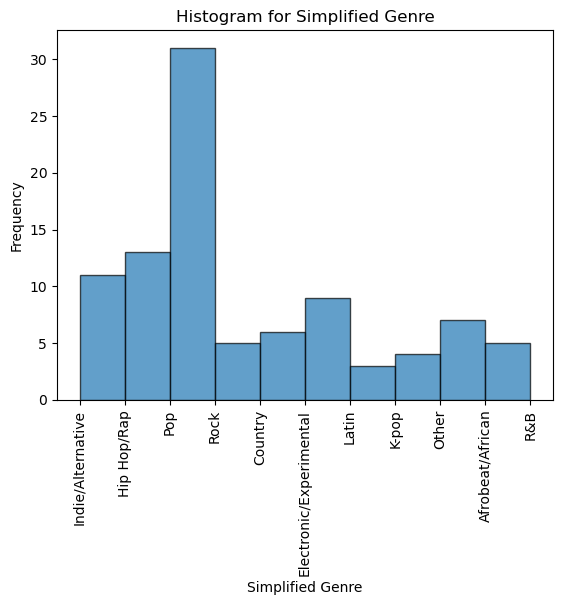

In [39]:
plt.hist(df_cl['Simplified Genre'], edgecolor='black', alpha=0.7)
plt.title(f"Histogram for Simplified Genre")
plt.xlabel("Simplified Genre")
plt.ylabel("Frequency")
plt.xticks(rotation=90) 
plt.show()

From this, we can see that pop clearly dominates the top of the charts, but there is still a lot of diversity in the genre.

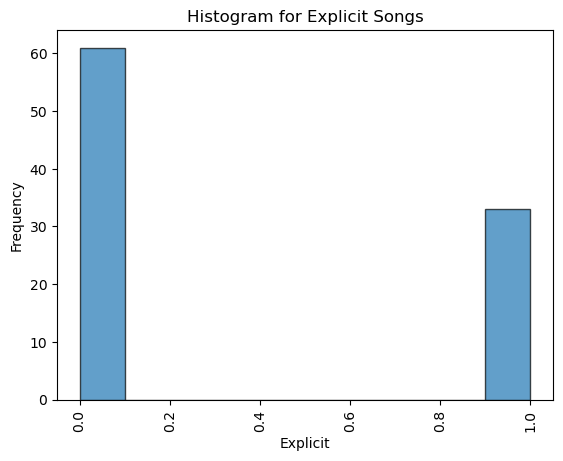

In [40]:
plt.hist(df_cl['Explicit'].astype(int), edgecolor='black', alpha=0.7)
plt.title(f"Histogram for Explicit Songs")
plt.xlabel("Explicit")
plt.ylabel("Frequency")
plt.xticks(rotation=90) 
plt.show()

Most songs are not explicit but some of them are.

### Bivariate and Multivariate Analysis

In [41]:
# Create a new column with bins of size 10
df_cl["Ranking Group"] = pd.cut(
    df_cl["Song Rank"], 
    bins=range(0, 101, 10),
    labels=[f"{i+1}-{i+10}" for i in range(0, 100, 10)],
    right=True
)
df_cl["Top 10 Song"] = df_cl["Song Rank"].apply(lambda x: 1 if x <= 10 else 0)
df_cl[["Ranking Group", "Song Rank", "Top 10 Song"]]


,Ranking Group,Song Rank,Top 10 Song
0,1-10,1,1
1,1-10,2,1
2,1-10,3,1
3,1-10,4,1
4,1-10,5,1
...,...,...,...
89,91-100,96,0
90,91-100,97,0
91,91-100,98,0
92,91-100,99,0


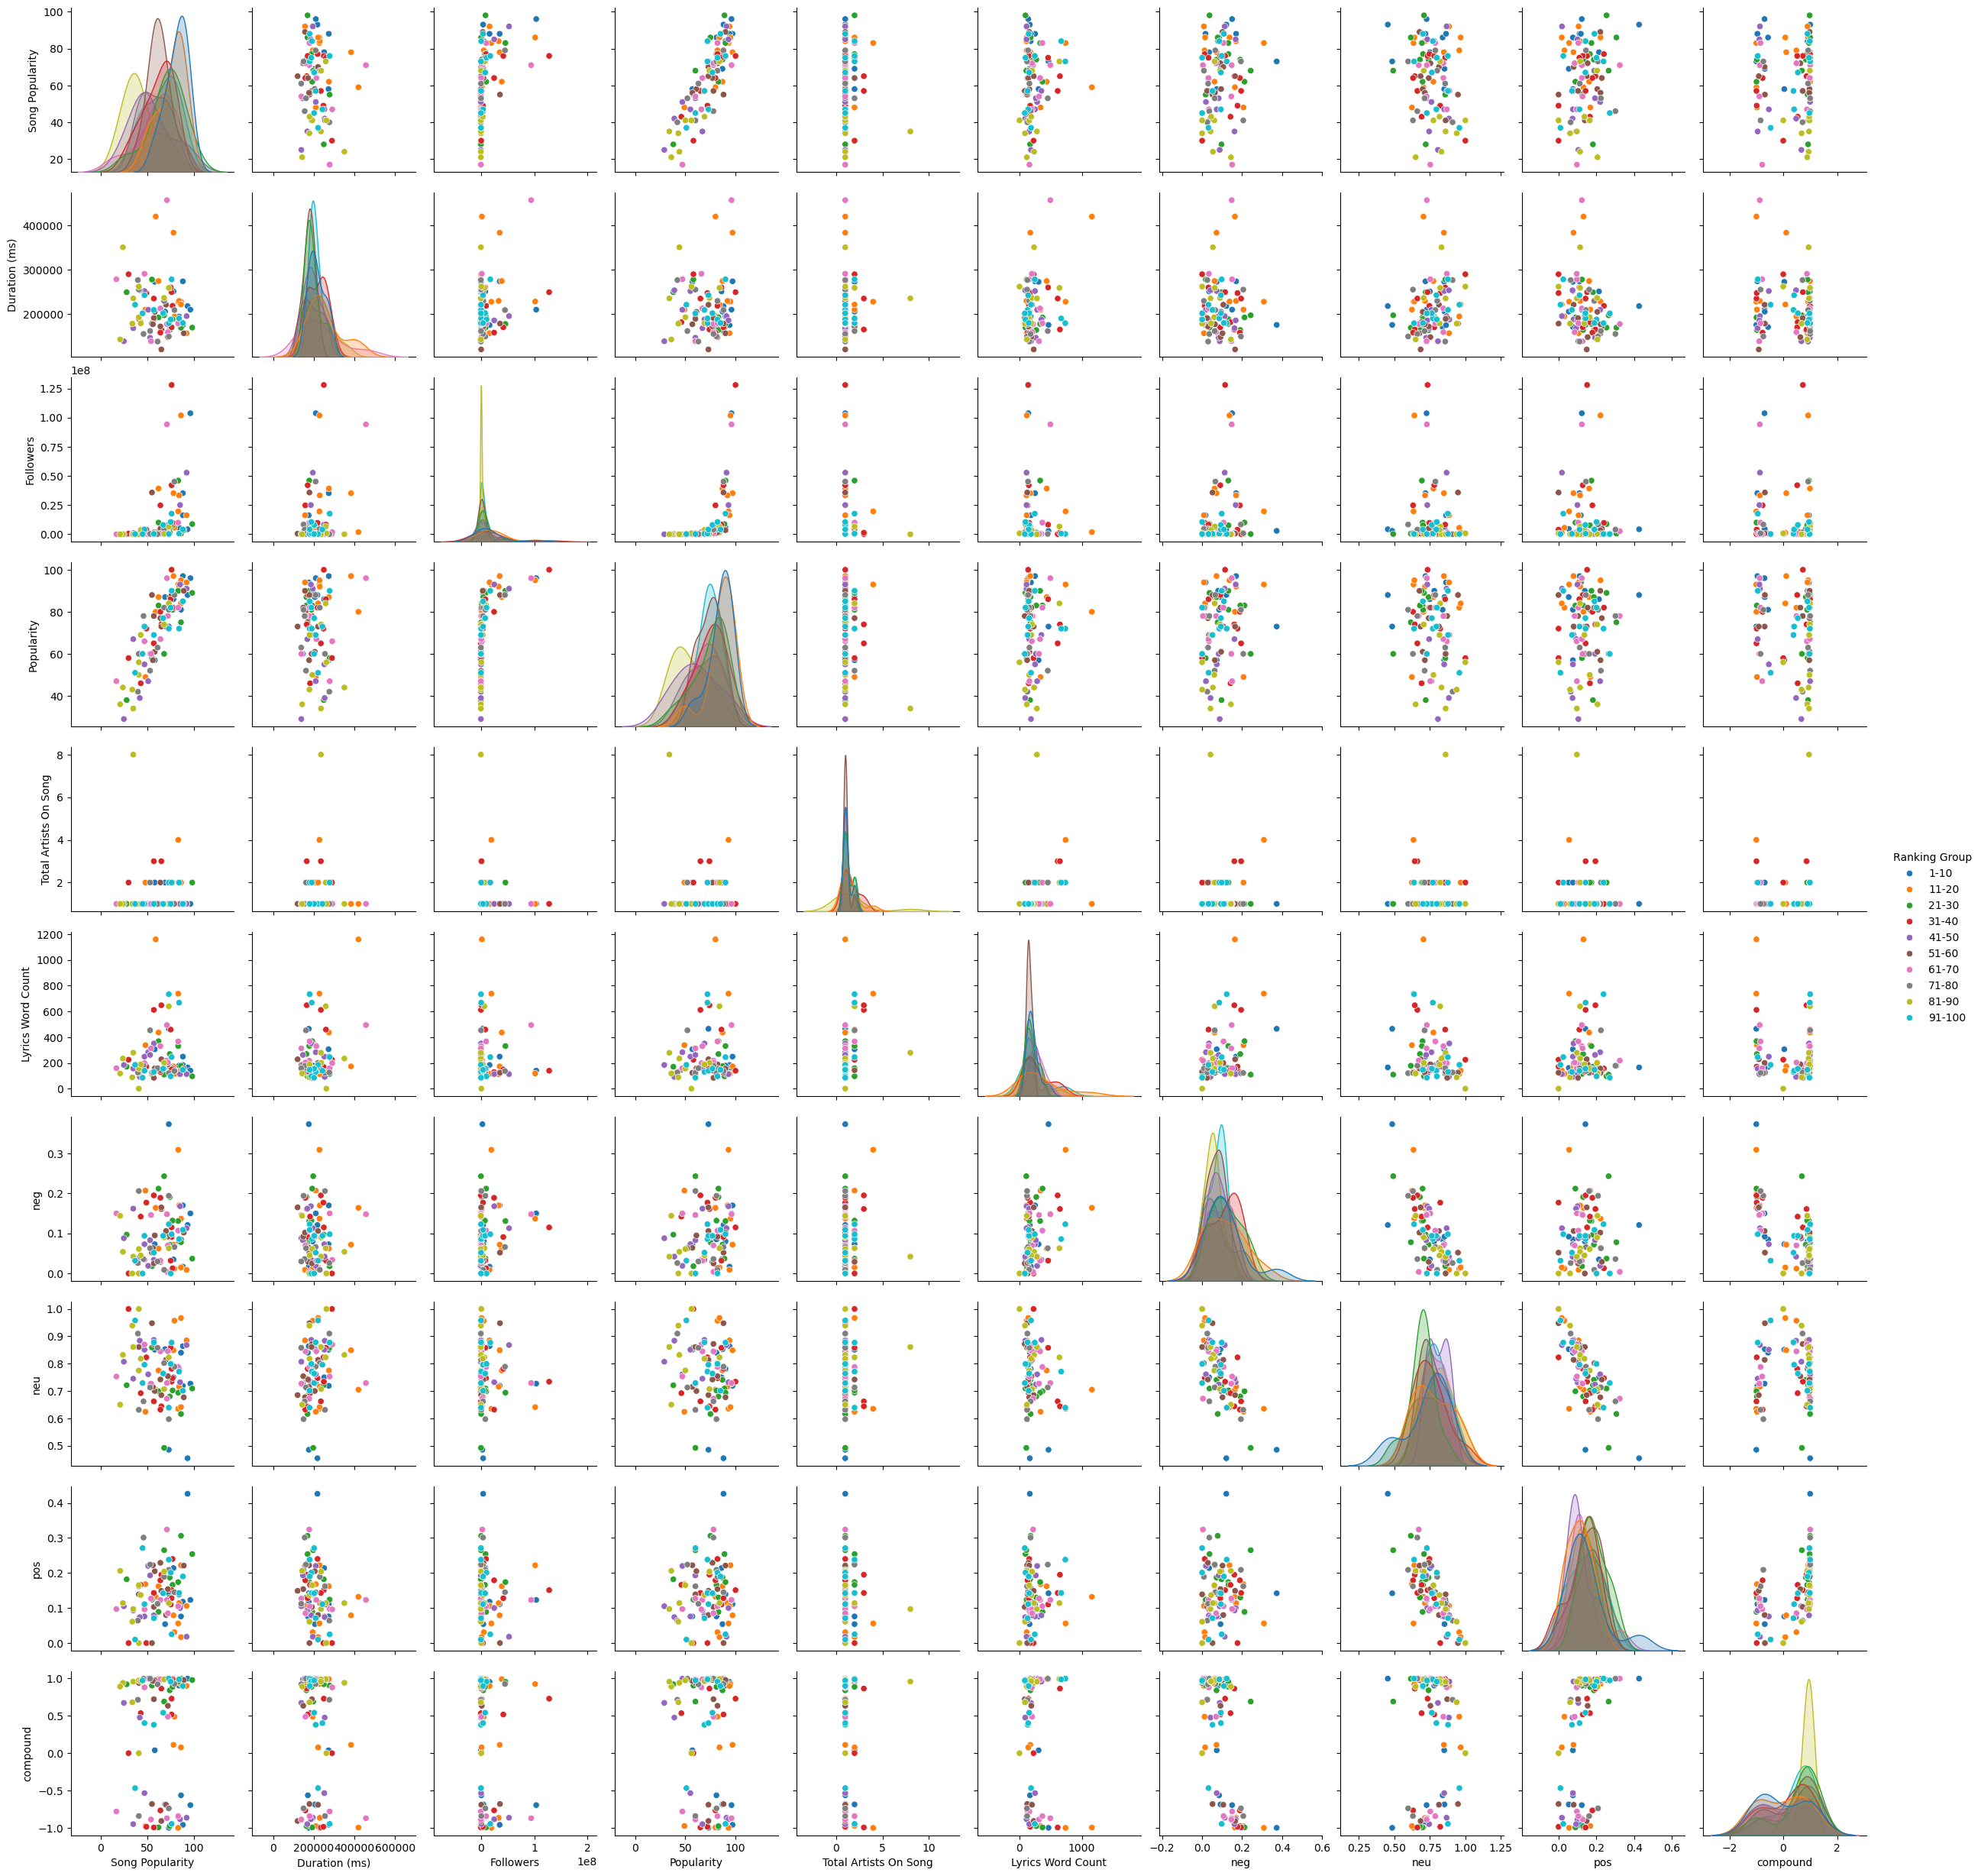

In [42]:
sns.pairplot(df_cl[['Song Popularity', 'Duration (ms)', 'Followers', 'Popularity', 'Total Artists On Song', 'Lyrics Word Count', 'neg', 'neu', 'pos', 'compound', 'Ranking Group']], hue="Ranking Group")

The above graph is a pairplot of the numeric columns and the hue is the ranking groups that I made to bin ranking by groups of 10. I'm not seeing any clear clusters appearing here between any of the variables. There is a positive linear relationship between artist popularity and song popularity though. This might be expected due to the way that spotify calculates this popularity and this high correlation might mean we should remove one of these variables when creating models.

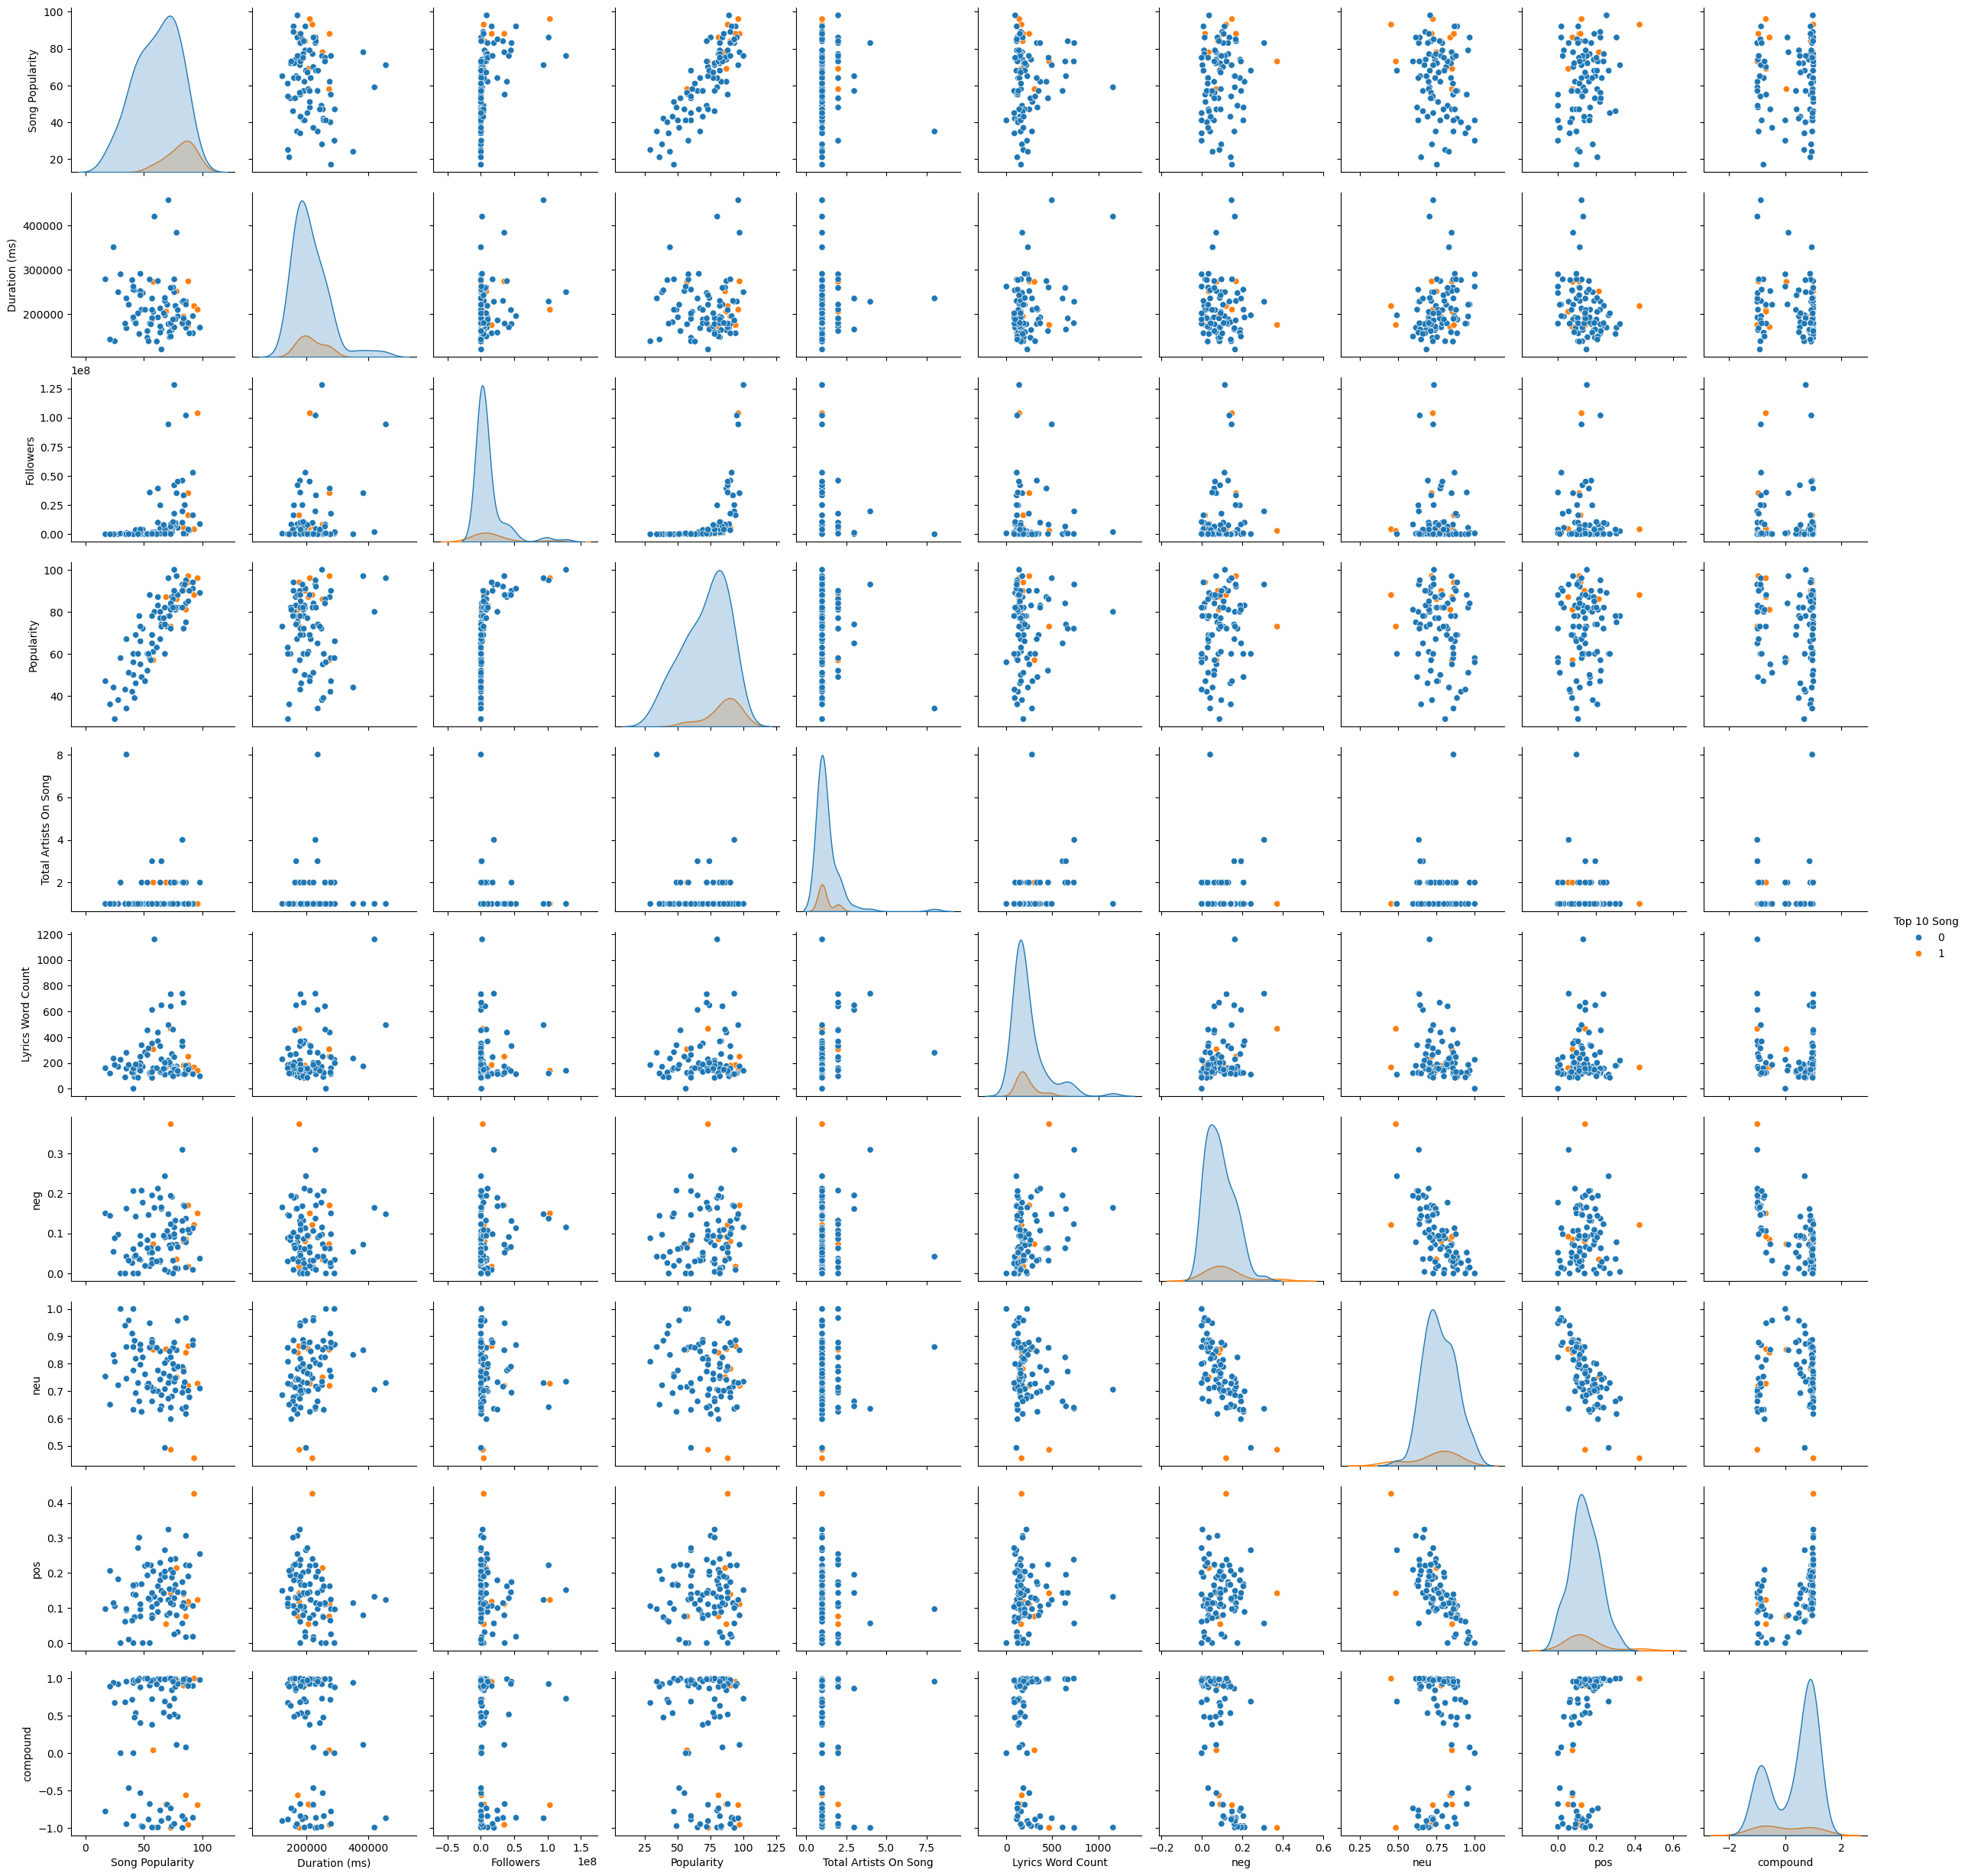

In [43]:
sns.pairplot(df_cl[['Song Popularity', 'Duration (ms)', 'Followers', 'Popularity', 'Total Artists On Song', 'Lyrics Word Count', 'neg', 'neu', 'pos', 'compound', 'Top 10 Song']], hue="Top 10 Song")

This is a pairplot where only the top 10 songs are colored. There aren't many clear distinctions but I am curious about the clustering in the scatter plot between song popularity and song duration as well as song popularity and positive sentiment score.

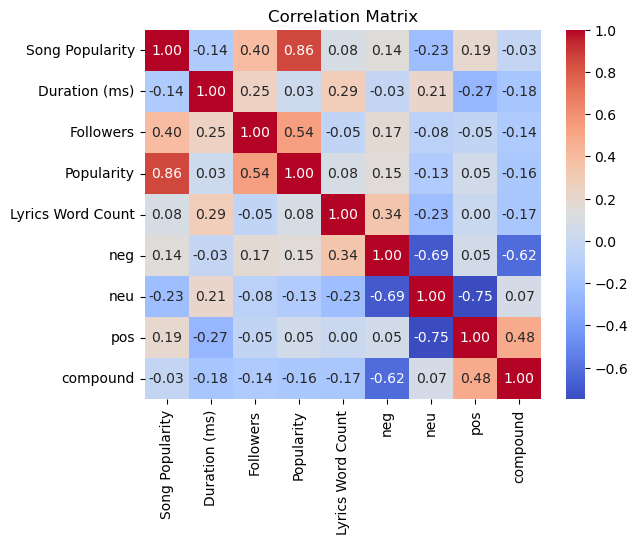

In [44]:
corr = df_cl[['Song Popularity', 'Duration (ms)', 'Followers', 'Popularity', 
              'Lyrics Word Count', 'neg', 'neu', 'pos', 'compound']].corr()

# Plot the correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

This correlation plot confirms my earlier observations about popularity and song popularity being highly correlated. It also shows the relationships between the various outputs of VADER which is to be expected and might require that we only use one of the 4 output scores during analysis. There is also the obvious correlation between lyrics word count and duration, although I expected this to be much higher. I think the slight correlation between negative lyric sentiment and lyric word count is interesting. There is also a slight negative correlation between positive lyric sentiment and song duration.

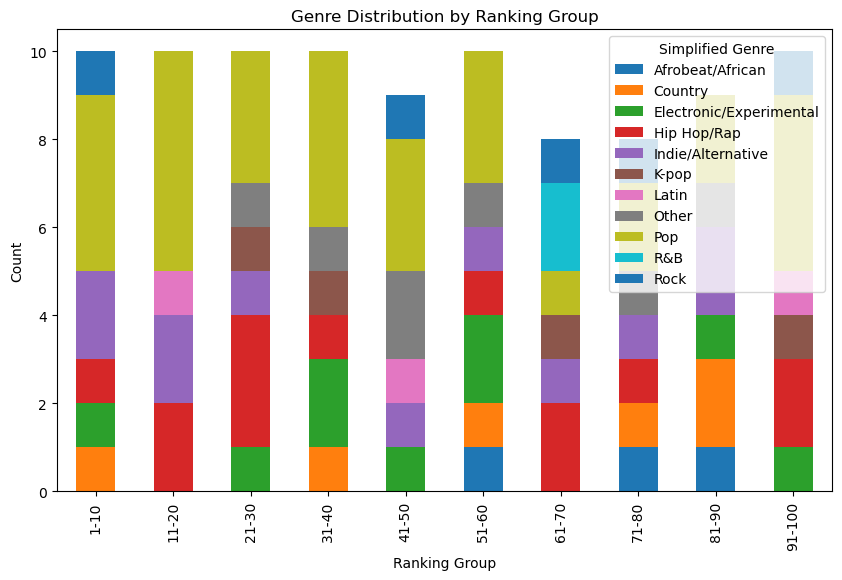

In [45]:
genre_counts = df_cl.groupby(['Ranking Group', 'Simplified Genre'], observed=True).size().unstack()
genre_counts.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Genre Distribution by Ranking Group")
plt.xlabel("Ranking Group")
plt.ylabel("Count")
plt.show()

This is a breakdown of the genres by ranking group. The distribution of genres seems to be unchanged across the different ranking groups (as in there is a mix of genres across each group). However, some genres don't appear at all in the top 20, including K-Pop and R&B.

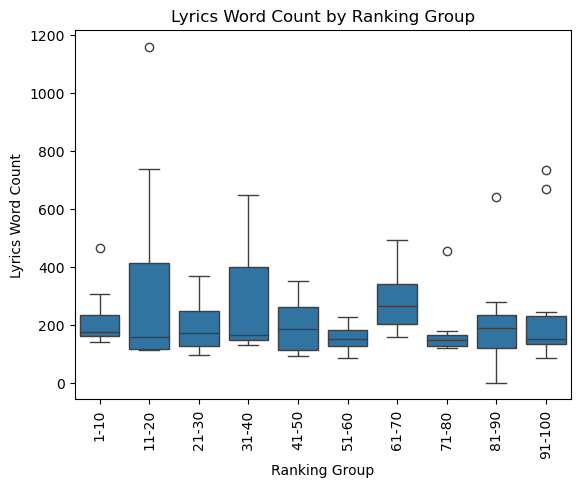

In [46]:
sns.boxplot(data=df_cl, x='Ranking Group', y='Lyrics Word Count')
plt.title("Lyrics Word Count by Ranking Group")
plt.xticks(rotation=90)
plt.show()

This is a breakdown of the word count by group, with the highest and lowest word count groups not being in the top 10. 

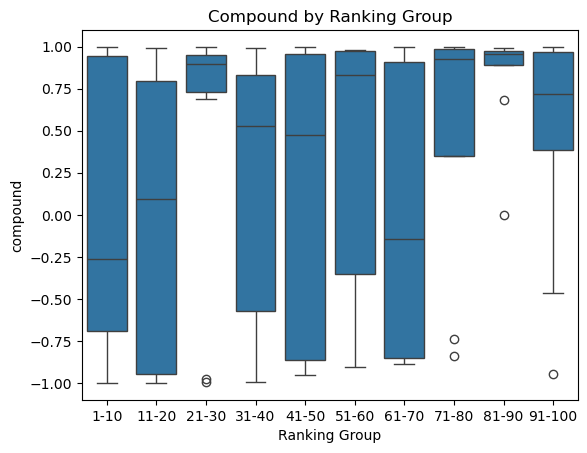

In [47]:
sns.boxplot(data=df_cl, x='Ranking Group', y='compound')
plt.title("Compound by Ranking Group")
plt.show()

This is a graph of the compound score by ranking group. Overall, the median seems to increase as the rankings increase, possibly indicating that songs that are ranked higher are less positive (or even negative).

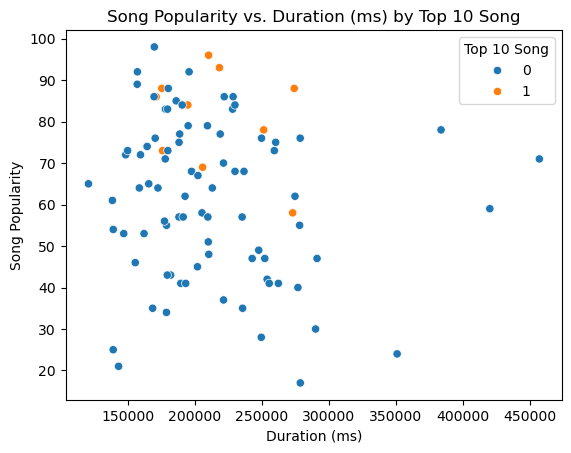

In [48]:
sns.scatterplot(x='Duration (ms)', y='Song Popularity', hue='Top 10 Song', data=df_cl)
plt.title("Song Popularity vs. Duration (ms) by Top 10 Song")
plt.show()

This scatter plot shows the Duration of the song vs it's popularity. It seems that the most popular songs are between 150000 and 275000 ms, with most of the top 10 songs falling between 175000 and 225000.

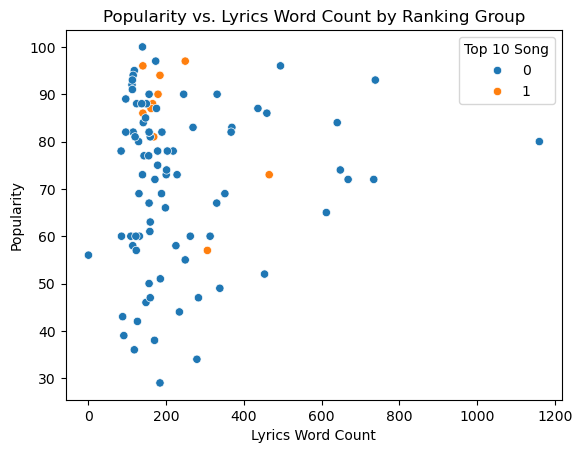

In [49]:
sns.scatterplot(x='Lyrics Word Count', y='Popularity', hue='Top 10 Song', data=df_cl)
plt.title("Popularity vs. Lyrics Word Count by Ranking Group")
plt.show()


This scatter plot shows the word count of the song vs it's popularity. Most of the top 10 songs are concentrated between 150 and 300, with only 2 outliers for this.

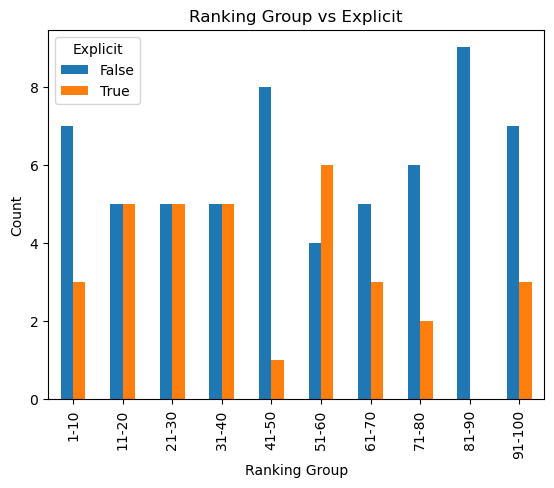

In [50]:
# Create crosstab for Ranking Group vs Explicit
explicit_ranking_crosstab = pd.crosstab(df_cl['Ranking Group'], df_cl['Explicit'])

# Plot a grouped bar plot
explicit_ranking_crosstab.plot(kind='bar', stacked=False)
plt.title('Ranking Group vs Explicit')
plt.xlabel('Ranking Group')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Explicit')
plt.show()


This graph shows the distribution of explicit songs in each category. For the middle categories, it is interesting that there is a perfect split between explicit and not explicit songs. The top category has far more non explicit songs compared to explicit songs. This is also true of the bottom categories, however, so this might not be the most predictive feature.

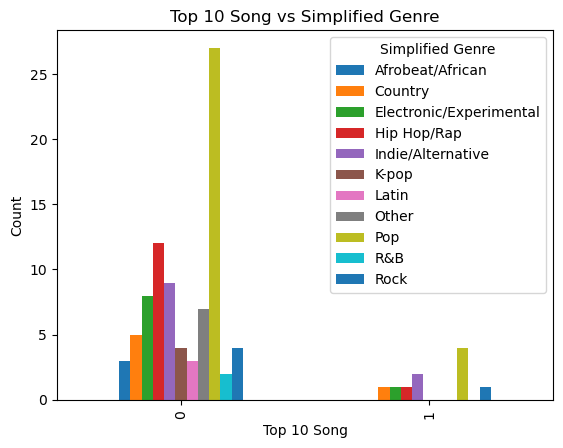

In [51]:
# Create crosstab for Top 10 Song vs Simplified Genre
top10_genre_crosstab = pd.crosstab(df_cl['Top 10 Song'], df_cl['Simplified Genre'])

# Plot a grouped bar plot
top10_genre_crosstab.plot(kind='bar', stacked=False)
plt.title('Top 10 Song vs Simplified Genre')
plt.xlabel('Top 10 Song')
plt.ylabel('Count')
plt.legend(title='Simplified Genre')
plt.show()


This is another look at the distribution of genres between top 19 songs and not top 10 songs. There are a lot of cateogries missing from the top 10 and the heaviest weight is on pop and indie, which could be a good predictor of the top songs.

### Data Distribution and Normalization

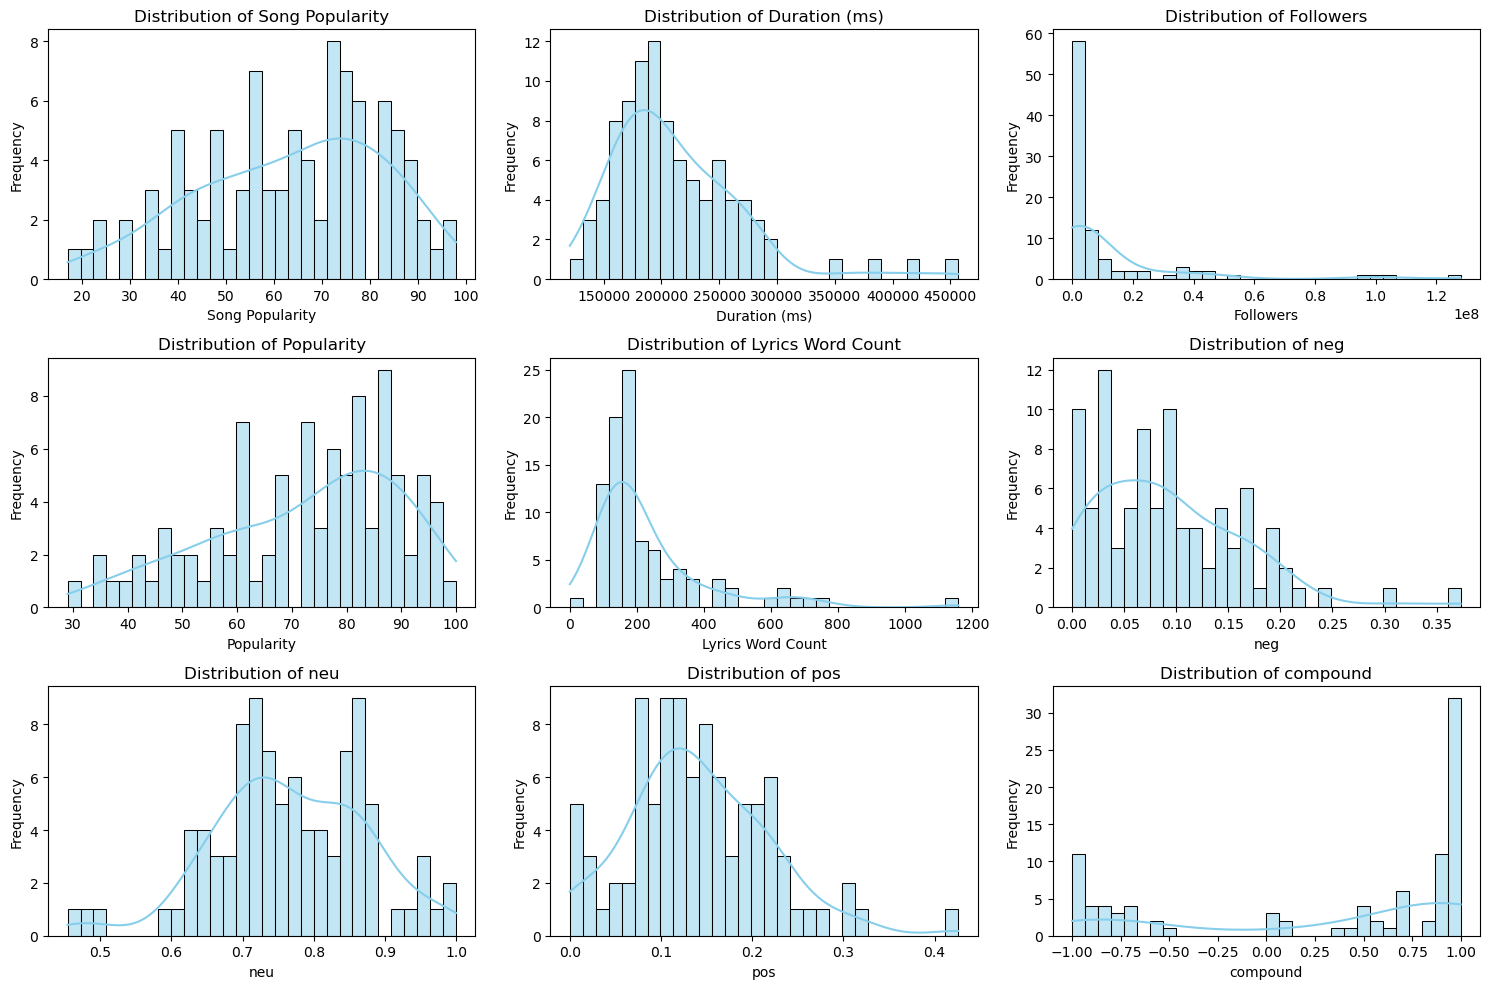

In [53]:
continuous_columns = ['Song Popularity', 'Duration (ms)', 'Followers', 'Popularity', 'Lyrics Word Count', 'neg', 'neu', 'pos', 'compound']

# Create histograms and density plots for each continuous column
plt.figure(figsize=(15, 10))

for i, column in enumerate(continuous_columns, 1):
    plt.subplot(3, 3, i)  # 3 rows, 4 columns
    sns.histplot(df_cl[column], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


This is a figure for a histogram and density plot for each of the continuous variables of interest.

- Song popularity: roughly bell shaped, some skewing, most songs between 40-90 - relatively evenly distributed with a more songs having a higher popularity
- Duration: high right skew, most songs are shorter (2.5-3 minutes) with very few songs having longer durations
- Followers: highly skewed, few artists have a large number of followers while most have low follower counts
- Artist Popularity: rough bell curve, somewhat skewed, concentrated in 70-90 range, most songs come from popular artists
- Word Count: most have fewer than 200 words, right skew
- Negative sentiment: Relatively even spread from 0-0.3, most have low neg sentiment
- Netural sentiment: most between 0.7-0.9, pretty even, most have medium to high neutral
- Positive sentimet: slightly bell shaped, right skew, scores between 0.05-0.15, pretty low pos sentiment overall
- Compound: mis of pos and neg values but most are closer to 0 than extremes (except for positive 1)

Most of the variables are skewed. Some variable might be normal-like but are still skewed.

In [54]:
skewness = df_cl[continuous_columns].apply(skew)
kurt = df_cl[continuous_columns].apply(kurtosis)

print("Skewness:")
print(skewness)
print("\nKurtosis:")
print(kurt)


Skewness:
Song Popularity     -0.377718
Duration (ms)        1.665246
Followers            3.097444
Popularity          -0.588679
Lyrics Word Count    2.480521
neg                  1.076954
neu                 -0.235075
pos                  0.610432
compound            -0.647878
dtype: float64

Kurtosis:
Song Popularity     -0.671813
Duration (ms)        4.075121
Followers            9.910030
Popularity          -0.565867
Lyrics Word Count    7.537863
neg                  1.705756
neu                  0.266109
pos                  1.037166
compound            -1.363075
dtype: float64


The skewness and kurtosis test results confirm the above findings. Followers, Duration, and Lyrics Word Count all have a highly positive kurtosis, indicating a lot of outliers. I will apply a log transformation to these variables to try to decrease this skewness.

In [55]:
# Apply log transformation to variables with high skewness
df_cl['Duration (ms)_transf'] = np.log1p(df_cl['Duration (ms)'])
df_cl['Followers_transf'] = np.log1p(df_cl['Followers'])
df_cl['Lyrics Word Count_transf'] = np.log1p(df_cl['Lyrics Word Count'])

# Check the transformations
df_cl[['Duration (ms)_transf', 'Followers_transf', 'Lyrics Word Count_transf']].describe()


,Duration (ms)_transf,Followers_transf,Lyrics Word Count_transf
count,94.000000,94.000000,94.000000
mean,12.234224,14.219630,5.231510
std,0.244274,2.462787,0.776593
min,11.701834,7.149917,0.000000
25%,12.075974,12.305041,4.893915
50%,12.189590,14.351124,5.135781
75%,12.393800,15.971873,5.559481
max,13.032294,18.667552,7.057037


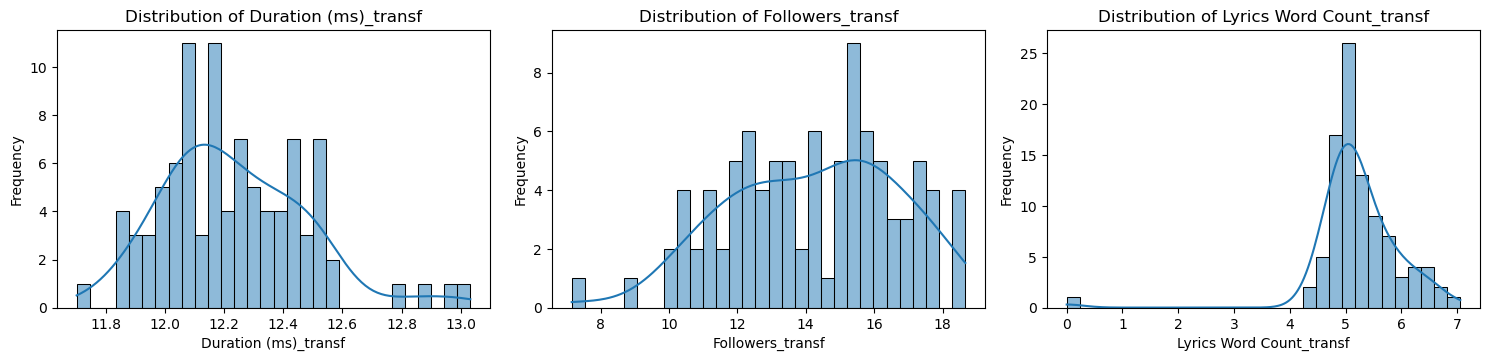

In [56]:
# Create histograms and density plots for each continuous column
plt.figure(figsize=(15, 10))

for i, column in enumerate(['Duration (ms)_transf', 'Followers_transf', 'Lyrics Word Count_transf'], 1):
    plt.subplot(3, 3, i)  # 3 rows, 4 columns
    sns.histplot(df_cl[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


I decided to apply a log transformation to Duration, Followers, and Word Count so that their distributions would be much less skewed. After looking at the histograms and density plots, I can see that this in fact helped the skewness and helped make the data more normal. Doing this will allow for clustering models to fit better on the data and make for a more clear insights about the data. It also decreases the outliers that'll impact the model. The next step is rescaling the data to make the range of data the same across all of the features.

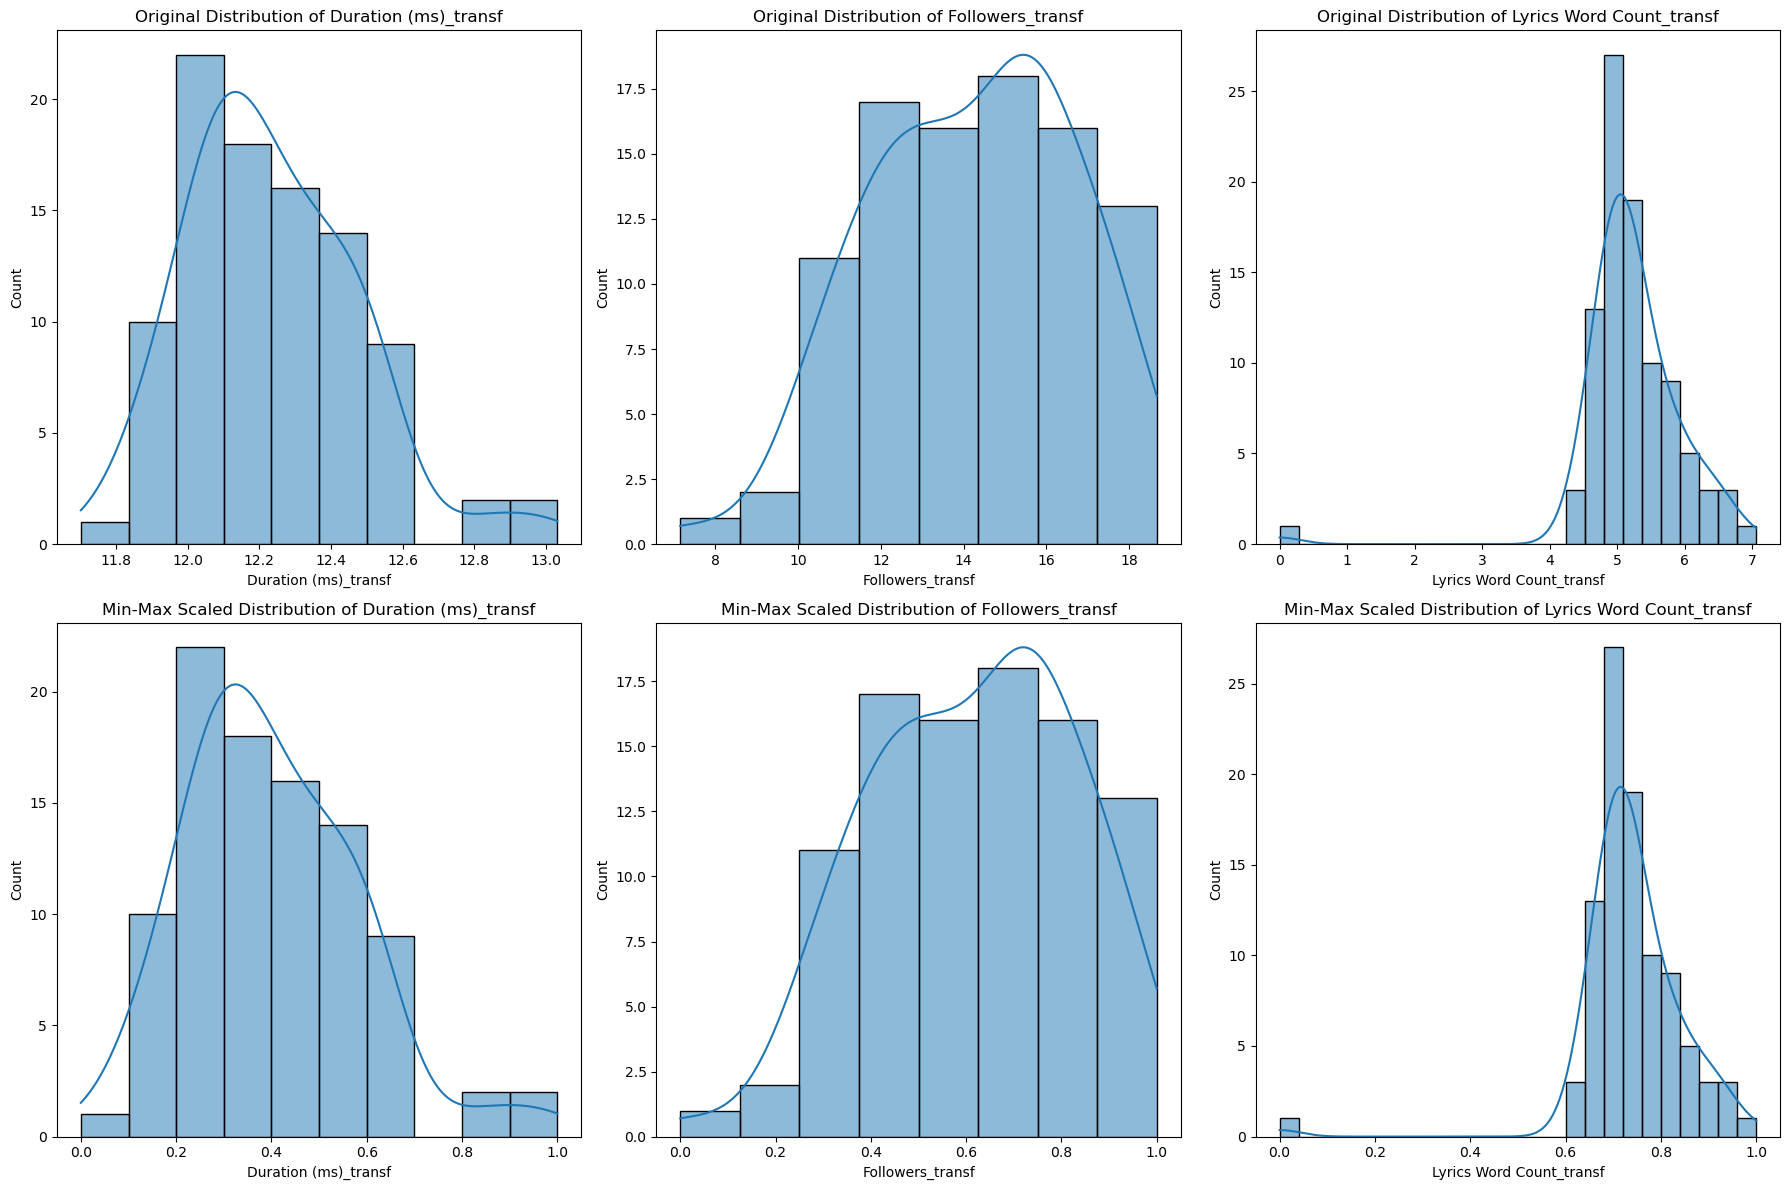

In [57]:
# Turn percentages back into decimals
df_cl['Popularity'] = df_cl['Popularity']/100
df_cl['Song Popularity'] = df_cl['Song Popularity']/100

# Selecting columns that were transformed
columns_to_normalize = ['Duration (ms)_transf', 'Followers_transf', 'Lyrics Word Count_transf']

# Initialize scalers
min_max_scaler = MinMaxScaler()

# Apply Min-Max Scaling
df_cl_minmax = df_cl[columns_to_normalize].copy()
df_cl_minmax[columns_to_normalize] = min_max_scaler.fit_transform(df_cl_minmax[columns_to_normalize])

# Plotting the results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Original distributions
for i, column in enumerate(columns_to_normalize):
    sns.histplot(df_cl[column], kde=True, ax=axes[0, i])
    axes[0, i].set_title(f"Original Distribution of {column}")
    
# Normalized distributions
for i, column in enumerate(columns_to_normalize):
    sns.histplot(df_cl_minmax[column], kde=True, ax=axes[1, i])
    axes[1, i].set_title(f"Min-Max Scaled Distribution of {column}")

plt.tight_layout()
plt.show()


In [58]:
df_cl[columns_to_normalize] = df_cl_minmax[columns_to_normalize]
df_cl.describe()

,Song Popularity,Duration (ms),Song Rank,Followers,Popularity,Total Artists On Song,Lyrics Word Count,neg,neu,pos,compound,Top 10 Song,Duration (ms)_transf,Followers_transf,Lyrics Word Count_transf
count,94.000000,94.000000,94.000000,9.400000e+01,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.00000,94.000000,94.000000,94.000000,94.000000
mean,0.635106,212252.319149,49.372340,1.163717e+07,0.726277,1.319149,233.702128,0.092543,0.767011,0.140436,0.29302,0.106383,0.400155,0.613816,0.741318
std,0.192280,57749.294460,29.438467,2.373635e+07,0.172284,0.882479,179.263177,0.071248,0.107798,0.077664,0.79927,0.309980,0.183601,0.213827,0.110045
min,0.170000,120792.000000,1.000000,1.273000e+03,0.290000,1.000000,0.000000,0.000000,0.454000,0.000000,-0.99980,0.000000,0.000000,0.000000,0.000000
25%,0.482500,175601.000000,24.250000,2.208655e+05,0.600000,1.000000,132.500000,0.034250,0.701250,0.093750,-0.68960,0.000000,0.281211,0.447585,0.693480
50%,0.660000,196731.500000,48.500000,1.710836e+06,0.770000,1.000000,169.000000,0.084000,0.757500,0.131000,0.71875,0.000000,0.366607,0.625233,0.727753
75%,0.777500,241314.500000,75.500000,8.641217e+06,0.867500,1.000000,258.750000,0.140750,0.851000,0.189750,0.96500,0.000000,0.520095,0.765952,0.787792
max,0.980000,456933.000000,100.000000,1.280014e+08,1.000000,8.000000,1160.000000,0.373000,1.000000,0.426000,0.99840,1.000000,1.000000,1.000000,1.000000


Using min-max scaling on these 3 columns changes them from a scale on the hundreds of thousands to a scale from 0 to 1. This will make sure that these features don't disproportionately have a bigger influence on a model. It also puts these features on an equal scale as all of the other features which will be very beneficial when running clustering algorithms.

In [59]:
df_cl.to_csv('../../data/processed-data/transformed_data.csv', index=False)

### Statistical Insights

I want to run a t-test on the two groups (top 10 songs vs not) to see if there is a difference in all of the different variables between the two groups. I decided to write a function that accomplishes this and then prints out the correct conclusion based on the resulting p-value.

In [60]:
def t_test_top_10(df, test_col):
    top_10 = df[df['Top 10 Song'] == 1][test_col]
    not_top_10 = df[df['Top 10 Song'] == 0][test_col]
    t_stat, p_val = ttest_ind(top_10, not_top_10, equal_var=False)

    if p_val < 0.05:
        print("Test on " + test_col)
        print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.4f}")
        print(f"We can reject the null hypothesis and conclude that the difference in {test_col} between Top 10 Songs and others is statistically significant")
    # else:
    #     print(f"We fail to reject the null hypothesis and can't conclude that there is a statistically significant difference in {test_col} between Top 10 Songs and others")

In [61]:
possible_columns = ['Song Popularity', 'Duration (ms)', 'Followers', 'Popularity', 'Total Artists On Song', 'Lyrics Word Count', 'neg', 'neu', 'pos', 'compound', 'Duration (ms)_transf', 'Followers_transf', 'Lyrics Word Count_transf']

for col in possible_columns:
    t_test_top_10(df_cl, col)

Test on Song Popularity
T-statistic: 4.6804, P-value: 0.0003
We can reject the null hypothesis and conclude that the difference in Song Popularity between Top 10 Songs and others is statistically significant
Test on Popularity
T-statistic: 3.2110, P-value: 0.0064
We can reject the null hypothesis and conclude that the difference in Popularity between Top 10 Songs and others is statistically significant
Test on Followers_transf
T-statistic: 2.4122, P-value: 0.0303
We can reject the null hypothesis and conclude that the difference in Followers_transf between Top 10 Songs and others is statistically significant


The variables that we can reject the null hypothesis include: Song Popularity, Artist Popularity, and Artist Followers. I think this means that we can say that the more popular an artist is, the more likely they are to have a song in the top 10. This is a very significant conclusion in terms of what it means for new artists trying to break into the industry.

Next, I wanted to run a 1 way Anova test on if there is a difference between the different ranking groups and the possible variables. Again, I printed out the results of the test pertaining to the hypotheses to see what I could conclude.

In [62]:
def one_way_ANOVA(df, test_col):
    group_1 = df[df['Ranking Group'] == '1-10'][test_col]
    group_2 = df[df['Ranking Group'] == '11-20'][test_col]
    group_3 = df[df['Ranking Group'] == '21-30'][test_col]
    group_4 = df[df['Ranking Group'] == '31-40'][test_col]

    # Perform ANOVA
    f_stat, p_val = f_oneway(group_1, group_2, group_3, group_4)

    # Output results
    if p_val < 0.05:
        print("Running test on " + test_col)
        print(f"F-statistic: {f_stat:.4f}, P-value: {p_val:.4f}")
        print(f"There are significant differences in {test_col} across Ranking Groups.")

In [63]:
for col in possible_columns:
    one_way_ANOVA(df_cl, col)

Running test on Song Popularity
F-statistic: 2.9815, P-value: 0.0441
There are significant differences in Song Popularity across Ranking Groups.


The only test that resulted in a significant difference between ranking groups is the Song Popularity, which makes sense because songs that are ranked more popular are ranked so because they have achieved success.

## Conclusions and Next Steps
### Summary of EDA Findings
From the exploratory data analysis, several important trends and patterns were identified:

#### Univariate Analysis
- **Genre Distribution**: Pop dominates the top 100 songs, but there is still a variety of other genres represented.
- **Compound Sentiment Scores**: Most songs exhibit very positive compound sentiment scores, with few songs having neutral scores. This suggests that emotional songs (either highly positive or highly negative) dominate.
- **Artist Representation**: There is a good presence of less popular artists achieving hits, suggesting opportunities for newer or niche artists.
- **Explicit Content**: While most songs are not explicit, a significant proportion still fall under the explicit category.

#### Bivariate Analysis
- **Artist and Song Popularity**: There is a strong positive linear relationship between artist popularity and song popularity, likely due to Spotify’s calculation methods.
- **VADER Sentiment Scores**: High correlation exists between the four VADER sentiment scores (positive, negative, neutral, compound) as expected.
- **Top 10 Songs**: These songs cluster together in terms of song popularity versus duration and song popularity versus positive score, indicating potential shared characteristics of highly successful songs.
- **Negative Sentiment and Song Length**: Slight positive correlation between negative sentiment scores and lyric word count suggests that longer songs tend to have more negative sentiment.
- **Positive Sentiment and Song Length**: A slight negative correlation between positive sentiment scores and song duration shows that shorter songs tend to have a more positive tone.
- **Lyric Word Count and Duration**: There is an obvious correlation between word count and song duration, though it is not as strong as initially expected.

#### Rankings
- **Genre Distribution by Rank**: All ranking bins show a wide variety of genres, but some (e.g., K-Pop, R&B) are not in the top 20 songs.
- **Sentiment and Rank**: The median compound sentiment score increases with rank, indicating that more positively emotional songs tend to achieve higher rankings.

#### Transformations
- Several variables, such as duration, artist followers, and lyric word count, exhibited skewness. Log transformation and min-max scaling successfully reduced these skews, preparing the data for further analysis.

#### Statistical Tests
- Variables such as song popularity, artist popularity, and artist followers showed statistically significant differences between the top 10 songs and other songs (via t-tests). This suggests that more popular artists are more likely to have a song in the top 10, which has major implications for emerging artists attempting to achieve similar success.

### Implications for Modeling

1. **Feature Selection**:
    - Key variables such as song popularity, artist popularity, compound sentiment scores, and explicit content should be included as potential predictors in the modeling process.
    - Variables like lyric word count and duration could also be significant based on their correlations with sentiment and popularity.

2. **Data Transformation**:
    - Skewed variables like duration, followers, and word count should use the log-transformed versions to improve model performance.
    - Min-max scaling is also recommended for these variables to ensure comparability in models sensitive to feature scaling.

The EDA successfully allowed us to explore the different features that we collected from various sources. With these insights and transformations, we can move forward to make models and better understand the underlying dynamics of this data.